# <center>Lab 7: Cost-sensitive classification, Class Imbalance and Fairness</center>
<center>DATA 558, Spring 2021</center>
<center>TAs: Alec Greaves-Tunnell and Ronak Mehta</center>


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, plot_roc_curve

## 0. Overview

In this lab, we will:
- Discuss metrics for evaluating classifier performance.
- Implement a weighting scheme for cost-sensitive classification.
- Implement resampling tools to handle class imbalance.
- Introduce and visualize nonlinear classification via kernel SVMs.
- Define, evaluate, and enforce fairness criteria for binary classifiers.

## 1. Cost-sensitive Classification

There are many cases of classification problems in which certain errors are *more critical* than others. Consider:

- **Example 1.1:** When designing a spam filter, a false positive, e.g. labeling an important email as spam, can be considered far worse than letting a bothersome email into the inbox.
- **Example 1.2:** On a computer network, flagging a normal user as suspicious might cause an inconvenience, but missing a hacker when in fact one is present can be far worse.

In such cases, we might want to weight certain errors differently.

### 1.1. Precision and Recall

To start, we define metrics that quantify more specific types of errors. Assume the binary classification setting, for which we have a test set $(x_1, y_1), ..., (x_m, y_m)$ with each $x_i \in \mathbb{R}^d$ and $y_i \in \{0, 1\}$, and a classifier $f: \mathbb{R}^d \rightarrow \{0, 1\}$ that we which to evaluate. Define

$$
\begin{align*}
TP &= \#_i\{f(x_i) = 1 \text{ and } y_i = 1\} = \text{Number of true positives.}\\
FP &= \#_i\{f(x_i) = 1 \text{ and } y_i = 0\} = \text{Number of false positives.}\\
TN &= \#_i\{f(x_i) = 0 \text{ and } y_i = 0\} = \text{Number of true negatives.}\\
FN &= \#_i\{f(x_i) = 0 \text{ and } y_i = 1\} = \text{Number of false negatives.}
\end{align*}
$$

Here, $\#_i\{E_i\}$ means the count of even $E_i$ over $i$. Using these, define
$$
\begin{align*}
\text{precision} &= \frac{TP}{TP + FP}\\
\text{recall} &= \frac{TP}{TP + FN}
\end{align*}
$$
Both include $TP$ over $TP$ plus a "false" term. Precision measures the proportion of true positives among all examples that the classifier claims to positive. Recall measures the proportion of true positives among all examples that are actually positive.

Consider the following set up. We have a dataset $\{(x_i, y_i)\}_{i=1}^n$ containinn $n_0$ examples with $y = 0$ and $x \sim \mathcal{N}(\mu_0, I)$ and $n_1$ examples with $y = 1$ and $x \sim \mathcal{N}(\mu_1, I)$. We train a logistic regression model to get the function $\hat{p}(y = 1 \mid x)$, but rather than classifying $\hat{y} = 1$ when $\hat{p}(y = 1 \mid x) > \frac{1}{2}$, we use an arbitrary threshold $\tau \in [0, 1]$, and define
$$
\begin{align*}
\hat{f}(x) = \begin{cases}
1 \text{ if } \hat{p}(y=1 \mid x) > \tau\\
0 \text{ otherwise.}
\end{cases}
\end{align*}
$$
**Exercise 1.1**: Implement the thresholding classifer below. (Hint: Check the `sklean` documentation to see how to get the probabilities of the classes out of a model.

In [2]:
def classify(X, model, threshold):
    """
    X: 2D numpy array.
    model: a LogisticRegression instance.
    threshold: a float in [0, 1].
    """
    ## <YOUR_CODE_HERE>
    probs = model.predict_proba(X)[:, 1]
    y_pred = (probs > threshold).astype(int)
    ##
    return y_pred

In [3]:
def generate_data(n0=1000, n1=1000, d=3):

    mu0 = -0.5 * np.ones(d)
    mu1 = 0.5 * np.ones(d)

    X = np.concatenate([np.random.normal(size=(n0, d)) + mu0, np.random.normal(size=(n1, d)) + mu1], axis=0)
    y = np.concatenate([np.repeat(0, n0), np.repeat(1, n1)])
    
    return X, y

In [4]:
np.random.seed(123)

X, y = generate_data()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

model = LogisticRegression().fit(X_train, y_train)

threshold = 0.5

y_pred = classify(X_test, model, threshold)

print(y_pred[0:10])
print(model.predict(X_test)[0:10])

[0 0 1 0 0 1 1 1 0 0]
[0 0 1 0 0 1 1 1 0 0]


**Exercise 1.2**: Implement a function that takes the true labels and the predicted labels, and returns $TP$, $FP$, $TN$, and $FN$.

In [5]:
def compute_confusion_metrics(y_true, y_pred):
    """
    y_true: 1D numpy array containing 0 and 1.
    y_pred: 1D numpy array containing 0 and 1.
    """
    
    ## <YOUR_CODE_HERE>
    tp = np.sum(y_true * y_pred)
    fp = np.sum((1 - y_true) * y_pred)
    tn = np.sum((1 - y_true) * (1 - y_pred))
    fn = np.sum(y_true * (1 - y_pred))
    ##
    
    return tp, fp, tn, fn

By definition of accuracy, it holds that.
$$
\text{accuracy} = \frac{TP + TN}{TP + FP + TN + FN}.
$$

In [6]:
from sklearn.metrics import accuracy_score

tp, fp, tn, fn = compute_confusion_metrics(y_test, y_pred)

print(accuracy_score(y_test, y_pred))
print((tp + tn) / (tp + fp + tn + fn))

0.8136363636363636
0.8136363636363636


**Exercise 1.3**: Implement precision and recall, using the above function.

In [7]:
def precision(y_true, y_pred):
    """
    y_true: 1D numpy array containing 0 and 1.
    y_pred: 1D numpy array containing 0 and 1.
    """
    ## <YOUR_CODE_HERE>
    tp, fp, tn, fn = compute_confusion_metrics(y_true, y_pred)
    prec = tp / (tp + fp)
    ##
    
    return prec

def recall(y_true, y_pred):
    """
    y_true: 1D numpy array containing 0 and 1.
    y_pred: 1D numpy array containing 0 and 1.
    """
    ## <YOUR_CODE_HERE>
    tp, fp, tn, fn = compute_confusion_metrics(y_true, y_pred)
    rec = tp / (tp + fn)
    ##
    
    return rec

In [8]:
from sklearn.metrics import precision_recall_fscore_support

prec = precision(y_test, y_pred)
rec = recall(y_test, y_pred)
prec_skl, rec_skl, _, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print("sklearn precision: %0.5f, versus ours: %0.5f" % (prec_skl, prec))
print("sklearn recall: %0.5f, versus ours: %0.5f" % (rec_skl, rec))

sklearn precision: 0.82515, versus ours: 0.82515
sklearn recall: 0.80299, versus ours: 0.80299


Now that we can compute everything, we can observe the crucial point: controlling the threshold allows use to achieve the desired balance of precision and recall. The first point to grasp is that there is a balance in the first place.

- If $\tau \nearrow 1$, precision $\nearrow 1$ and recall $\searrow 0$.
- If $\tau \searrow 0$, precision $\searrow \hat{p}(Y = 1)$ and recall $\nearrow 1$.

<font color='red'>**EDIT: The above has been updated to resolve a discussion from lecture. When $\tau \nearrow 1$, the classifier will always predict 0. This means that $TP = FP = 0$, so as long as $FN > 0$ (i.e. there is at least one positive exameple), we will have recall = 0. When $\tau \searrow 0$, the classifier will always predict 1, so $TP + FP = m$ (test set size), and precision = $\hat{p}(Y = 1)$, where $\hat{p}$ is estimated on the test set.**</font>

**Exercise 1.4**: Explain why the bullets above should make sense.

In [9]:
def run_experiment(n0=1000, n1=1000, threshold=0.5, verbose=False):
    np.random.seed(123)
    
    X, y = generate_data(n0=n0, n1=n1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
    model = LogisticRegression().fit(X_train, y_train)
    y_pred = classify(X_test, model, threshold)
    
    prec = precision(y_test, y_pred)
    rec = recall(y_test, y_pred)
    
    if verbose:
        print("Setting:")
        print("---------------------------")
        print("n0 = %d" % n0)
        print("n1 = %d" % n1)
        print("threshold = %0.4f" % threshold)
        print("---------------------------")
        print("precision: %0.5f" % prec)
        print("recall: %0.5f" % rec)
        print("---------------------------\n")
        
    return prec, rec

In [10]:
run_experiment(threshold = 0.99, verbose = True)
run_experiment(threshold = 0.01, verbose = True)

Setting:
---------------------------
n0 = 1000
n1 = 1000
threshold = 0.9900
---------------------------
precision: 1.00000
recall: 0.05075
---------------------------

Setting:
---------------------------
n0 = 1000
n1 = 1000
threshold = 0.0100
---------------------------
precision: 0.51938
recall: 1.00000
---------------------------



(0.5193798449612403, 1.0)

Finally, we can visualize the precision and recall that we get for different values of the threshold by plotting them against each other in a **PR curve**.

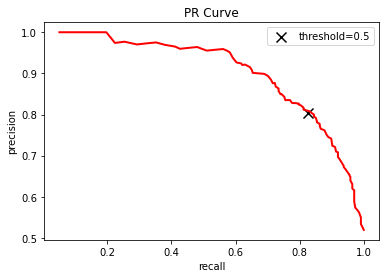

In [11]:
thresholds = np.linspace(0.01, 0.99, 100)

precs = []
recs = []
for threshold in thresholds:
    prec, rec = run_experiment(n0=1000, n1=1000, threshold=threshold)
    precs.append(prec)
    recs.append(rec)
    

plt.plot(recs, precs, color="red", linewidth=2)
prec, rec = run_experiment(n0=1000, n1=1000, threshold=0.5)
plt.scatter(prec, rec, marker="x", s=100, color="black", label="threshold=0.5")
plt.legend()
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("PR Curve")
plt.show()

We know that precision and recall are in competition when the threshold gets close to the boundaries. However, that does not mean that a classifier cannot have high precision and recall for many values of the threshold. While we can compute precision and recall for various values of the threshold, it might be nice to summarize thre performance of classifier for all thresholds.

To do this, we plot a similar curve called the **receiver operating charactaristic (ROC) curve**. First, define the **true positive rate** $TPR$ as
$$
TPR = \frac{TP}{TP + FN},
$$
and the **false positive rate** $FPR$ as
$$
FPR = \frac{FP}{FP + TN}
$$
The $TPR$ is the proportion of positive predictions among those actually positive, whereas the $FPR$ is the proportion of positive predictions among those actually negative.

**Exercise 1.5:** How are $TPR$ and $FPR$ related to precision and recall?

The ROC curve plots $TPR$ against $FPR$.

In [12]:
def tpr(y_true, y_pred):
    
    ## <YOUR_CODE_HERE>
    TPR = recall(y_true, y_pred)
    ##
    
    return TPR

def fpr(y_true, y_pred):
    
     ## <YOUR_CODE_HERE>
    tp, fp, tn, fn = compute_confusion_metrics(y_true, y_pred)
    FPR = fp / (fp + tn)
    ##
    
    return FPR

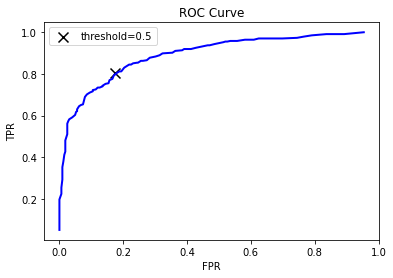

In [13]:
np.random.seed(123)
    
X, y = generate_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

model = LogisticRegression().fit(X_train, y_train)

thresholds = np.linspace(0.01, 0.99, 100)

tprs = []
fprs = []
accs = []
for threshold in thresholds:
    y_pred = classify(X_test, model, threshold)
    tprs.append(tpr(y_test, y_pred))
    fprs.append(fpr(y_test, y_pred))
    accs.append(accuracy_score(y_test, y_pred))
    
threshold_results = {
    'x' : thresholds,
    'precs' : precs,
    'recs' : recs,
    'fprs' : fprs,
    'accs' : accs
}


plt.plot(fprs, tprs, color="blue", linewidth=2)

y_pred = classify(X_test, model, 0.5)
plt.scatter(fpr(y_test, y_pred), tpr(y_test, y_pred), marker="x", s=100, color="black", label="threshold=0.5")

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

A "good classifier" can, for many thresholds, have a high $TPR$ and a low $FPR$, thus we want the surve to be as concave as possible. Often, practitioners will report the **AUC**, which is the total area under the ROC curve. This metric is bounded between $1$ (indicating a very concave ROC curve) and $0$ (indicating a very convex ROC curve).

### 1.2. Cost-sensitive classification objective

First consider a binary classification problem. In the cost-sensitive setup, we are given a dataset of triples $(x_1, c_1^0, c_1^1), ..., (x_n, c_n^0, c_n^1)$, where 
- $x_i \in \mathbb{R}^d$ is the $i$-th feature vector, 
- $c_i^0 \geq 0$ is the "cost" of predicting class 0 for example $i$, and 
- $c_i^1 \geq 0$ is the "cost" of predicting class 1 for example $i$.
Let $f_\beta: \mathbb{R}^d \rightarrow \{0, 1\}$ be a function parametrized by $\beta$. In **cost-sensitive classification**, we wish to find the $\beta$ that solves
$$
\min_{\beta} \frac{1}{n}\sum_{i=1}^n f_\beta(x_i)\cdot c_i^1 + (1 - f_\beta(x_i)) \cdot c^0_i.
$$
Notice that this is a proper generalization of vanilla classification, in which $c^1_i = \mathbb{1}\{y_i=0\}$ and $c^0_i = \mathbb{1}\{y_i=1\}$, where $\mathbb{1}\{E\}$ is $1$ if the event $E$ is true and $0$ otherwise. 

While the framework is general enough to apply a different set of costs per class per example, it will be common and statistically convenient that we maintain the same costs across data points. In a the binary case, that corresponds to costs $c^0$ and $c^1$. 

To implement this in `sklearn`, many estimators have a `class_weight` hyperparameter, which represents the importants of classifying each class correctly. Crucially, weights and costs are opposite; by increasing $c^1$, we are pushing the classifier toward predicting class $0$, therefore increasing the importance of predicting $0$ when it is correct. Thus, we set `class_weight[0]` equal to $c^1$ and `class_weight[1]` equal to $c^0$. We will hold the threshold fixed, but reproduce the PR and ROC curves from before, by playing with the class weights.

**Exercise 1.6**: Implement the `evaluate_costs` function to return the precision, recall, and FPR given costs `c0` and `c1`.

In [14]:
def evalute_costs(c0, c1, X_train, X_test, y_train, y_test):
    
    # Compute y_pred from the right model.
    ## <YOUR_CODE_HERE>
    class_weight = {0 : c1, 1 : c0}
    model = LogisticRegression(class_weight=class_weight).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    ##
    
    prec = precision(y_test, y_pred)
    rec = recall(y_test, y_pred)
    FPR = fpr(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    return prec, rec, FPR, acc

In [15]:
def plot_pr_roc(precs, recs, fprs, point=None, label=None):
    fig, axes = plt.subplots(1, 2, figsize = (10, 5))

    if point is not None and label is not None:
        prec, rec, FPR, acc = point
        axes[0].scatter(rec, prec, marker="x", s=100, color="black", label=label)
        axes[1].scatter(FPR, rec, marker="x", s=100, color="black", label=label)

    axes[0].plot(recs, precs, color="red", linewidth=2)
    axes[0].set_xlabel("recall")
    axes[0].set_ylabel("precision")
    axes[0].set_title("PR Curve")
    axes[0].legend()

    axes[1].plot(fprs, recs, color="blue", linewidth=2)
    axes[1].set_xlabel("FPR")
    axes[1].set_ylabel("TPR")
    axes[1].set_title("ROC Curve")
    axes[1].legend()

    plt.show()

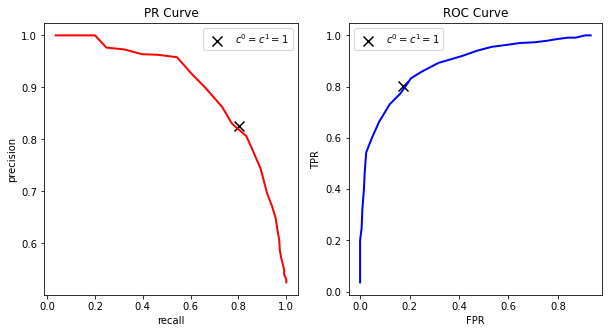

In [16]:
np.random.seed(123)
    
X, y = generate_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

costs = np.logspace(-2, 2, 30)

precs = []
recs = []
fprs = []
accs = []
for cost in costs:
    c0 = cost
    c1 = 1
    metrics = evalute_costs(c0, c1, X_train, X_test, y_train, y_test)
    
    precs.append(metrics[0])
    recs.append(metrics[1])
    fprs.append(metrics[2])
    accs.append(metrics[3])
    
cost_results = {
    'x' : costs,
    'precs' : precs,
    'recs' : recs,
    'fprs' : fprs,
    'accs' : accs
}

point = evalute_costs(1, 1, X_train, X_test, y_train, y_test)
label = r"$c^0=c^1=1$"

plot_pr_roc(precs, recs, fprs, point=point, label=label)

### 1.2. Class Imbalance

One final dial that allows us to walk along the precision-recall tradeoff is the number of points in either class. This dial is initially not set by us, but rather by nature. In real data, oftentimes the number of points in one class heavily outweighs the other. Note that while the previous sections explored when certain errors are *critical* this section will see what happens when certain errors are more *likely*. Examples and intuition usually carry over.

- **Example 1.1 Revisited:** Consider how many non-spam emails exist (likely many) versus the number of spam emails (likely much fewer).
- **Example 1.2 Revisited:** Consider how many examples of typical user behavior exist (likely many), versus the number of catalogued instances of malicious user behavior (likely much fewer). 

Consider the previous setup, but with $n0 >> n1$. How are precision and recall affected?

In [17]:
run_experiment(n0=1000, n1=1000, verbose=True)
run_experiment(n0=10000, n1=1000, verbose=True)
run_experiment(n0=100000, n1=1000, verbose=True)

Setting:
---------------------------
n0 = 1000
n1 = 1000
threshold = 0.5000
---------------------------
precision: 0.82515
recall: 0.80299
---------------------------

Setting:
---------------------------
n0 = 10000
n1 = 1000
threshold = 0.5000
---------------------------
precision: 0.69277
recall: 0.33923
---------------------------

Setting:
---------------------------
n0 = 100000
n1 = 1000
threshold = 0.5000
---------------------------
precision: 0.70588
recall: 0.03529
---------------------------



(0.7058823529411765, 0.03529411764705882)

Previously, we were able to control the threshold and costs for each prediction. What can we control here? We can artificially change the class sizes by **upsampling** (collecting more data from the minority class) or **downsampling** (reducing the amount of data in the majority class). Upsampling involves collecting more data, which comes with its own real-world considerations, such as time and budget constraints. Downsampling can be done just by sampling some number of points without replacement from the majority class.

You might think this alters the distribution of the data, and therefore is problematic. While it may be "problematic" in terms of optimizing accuracy, there are at least two distinct advantages.
- Many statistical procedures have better properties when the two datasets have similar class sizes, so this can loosely be thought of as trading a lot of variance for a little bit of bias.
- Evening out the classes might yield a better precision or recall, and as we will see later, help us satisfy fairness constraints that improve the social implications of our model.

**Exercise 1.7**: Implement the `downsample` function below. Ensure that the function yields reproducible results (i.e. will return the same answer from multiple calls).

In [18]:
def downsample(ratio, X_train, y_train):
    """
    ratio: float between 0 and 1 indicating what proportion of the majority class should remain.
    """
    ## <YOUR_CODE_HERE>
    np.random.seed(123)
    
    n = len(X_train)
    
    neg_idx = np.arange(n)[y_train==0]
    pos_idx = np.arange(n)[y_train==1]
    
    n0 = len(neg_idx)
    n1 = len(pos_idx)
    
    if n0 > n1:
        down_n0 = int(n0 * ratio)
        down_idx = np.random.choice(neg_idx, down_n0, replace=False)
        idx = np.concatenate([down_idx, pos_idx])
    else:
        down_n1 = int(n1 * ratio)
        down_idx = np.random.choice(pos_idx, down_n1, replace=False)
        idx = np.concatenate([neg_idx, down_idx])
        
    X_downsampled = X_train[idx]
    y_downsampled = y_train[idx]
    ##
    
    return X_downsampled, y_downsampled

def evalute_downsample(ratio, X_train, X_test, y_train, y_test):
    
    X_downsampled, y_downsampled = downsample(ratio, X_train, y_train)
    
    model = LogisticRegression().fit(X_downsampled, y_downsampled)
    y_pred = model.predict(X_test)
    
    prec = precision(y_test, y_pred)
    rec = recall(y_test, y_pred)
    FPR = fpr(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    return prec, rec, FPR, acc

First, we confirm that we are able to get the same PR and ROC curve structure by altering the downsampling ratio.

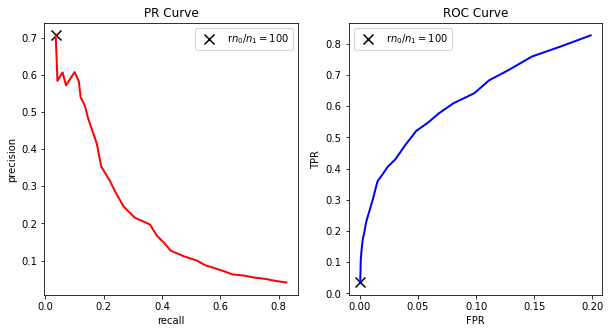

In [19]:
np.random.seed(123)
    
X, y = generate_data(n0=100000, n1=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

ratios = np.logspace(-2, 0, 30)

precs = []
recs = []
fprs = []
accs = []
for ratio in ratios:

    metrics = evalute_downsample(ratio, X_train, X_test, y_train, y_test)
    
    precs.append(metrics[0])
    recs.append(metrics[1])
    fprs.append(metrics[2])
    accs.append(metrics[3])
    
downsample_results = {
    'x' : ratios,
    'precs' : precs,
    'recs' : recs,
    'fprs' : fprs,
    'accs' : accs
}


point = evalute_downsample(1, X_train, X_test, y_train, y_test)
label = "r$n_0 / n_1 = 100$"

plot_pr_roc(precs, recs, fprs, point=point, label=label)

Finally, we revisit all of the methods that we have seen thus far, and bring back the accuracy for comparison.

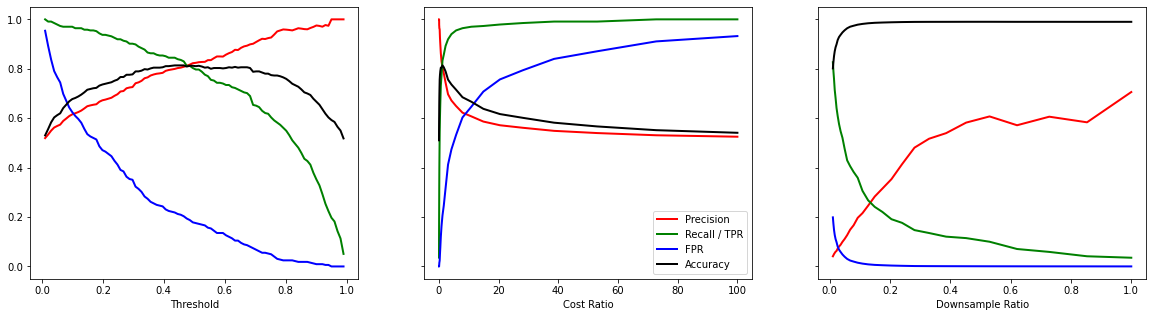

In [20]:
fig, axes = plt.subplots(1, 3, figsize = (20, 5), sharey=True)

results = [threshold_results, cost_results, downsample_results]

for i, result in enumerate(results):
    
    axes[i].plot(result['x'], result['precs'], color="red", linewidth=2, label="Precision")
    axes[i].plot(result['x'], result['recs'], color="green", linewidth=2, label="Recall / TPR")
    axes[i].plot(result['x'], result['fprs'], color="blue", linewidth=2, label="FPR")
    axes[i].plot(result['x'], result['accs'], color="black", linewidth=2, label="Accuracy")
    
axes[1].legend(loc="lower right")
axes[0].set_xlabel("Threshold")
axes[1].set_xlabel("Cost Ratio")
axes[2].set_xlabel("Downsample Ratio")

plt.show()

## 2.  Kernel-Based Methods

Up until this point, our classification toolkit has consisted entirely of logistic regression. There are many other classifiers, and many of them fall into the category of **kernel-based methods**. In short, kernel-based methods do not operate on the feature vectors $x_i \in \mathbb[R}^d$, but rather a matrix $K \in \mathbb{R}^{n \times n}$, where $K_{ij}$ is the "similarity" between example $x_i$ and $x_j$. 

Similarity is defined by a **kernel function** $k: \mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}$, such that
$$
K_{ij} = k(x_i, x_j)
$$
$K$ is then called the **Gram matrix** of vectors $x_1, ..., x_n \in \mathbb{R}^d$ with respect to kernel $k$.

A simple example of a kernel is the *dot product*.
$$
k(x_i, x_j) = x_i^\top x_j
$$
This is in many settings considered the standard kernel. In fact, even unsupervised learning algorithms such as PCA can be augmented with kernels, where using the dot product kernel reduces the algorithm to standard PCA.

Why might we want to introduce another similarity measure, as opposed to the dot product? The green stars below might be close in Euclidean space (hence have a high dot product), but may be considered far when accounting for the geometric of the classes. 

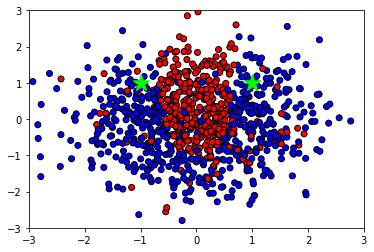

In [21]:
np.random.seed(123)

n = 1000

X = np.random.normal(size=(n, 2))
y = []
for x in X:
    if x[1] >= 10 * x[0] ** 4 - 1:
        y.append(np.random.binomial(1, 0.9, 1))
    else:
        y.append(np.random.binomial(1, 0.1, 1))
        
y = np.array(y).reshape((n,))

col = []
for i in range(n):
    if y[i] == 1:
        col.append("red")
    else:
        col.append("blue")

plt.scatter(X[:, 0], X[:, 1], c=col, edgecolor="k")
plt.scatter(-1, 1, color="lime", marker="*", s=300)
plt.scatter(1, 1, color="lime", marker="*", s=300)
plt.xlim((-3, 3))
plt.ylim((-3, 3))
plt.show()

One such kernel-based classifier is the **support vector machine (SVM)**. We will not dig too deep into the details of the method, as the API is generally the same as any other `sklearn` estimator. We use the `SVC` class (support vector classifier) to implement this method. 

In [22]:
# Source: https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html#sphx-glr-auto-examples-svm-plot-iris-svc-py

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

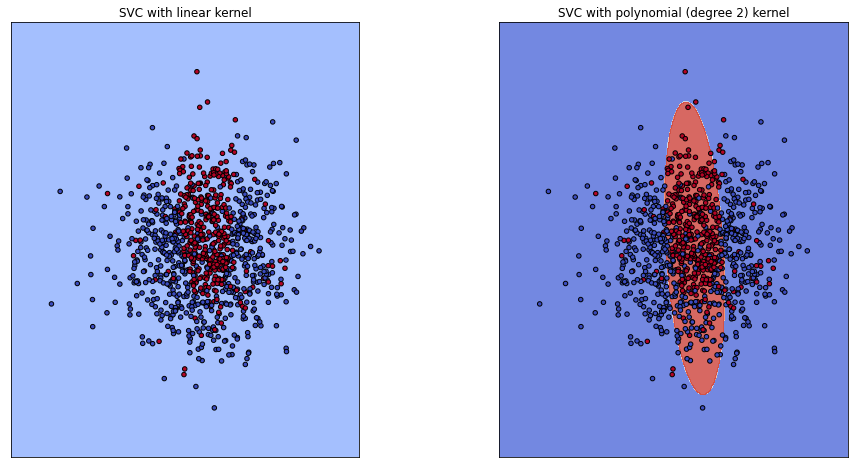

In [23]:
from sklearn import svm

models = (svm.SVC(kernel='linear'),
          svm.SVC(kernel='poly', degree=2))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'SVC with polynomial (degree 2) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(1, 2, figsize=(15, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

## 3. Fairness in machine learning

Finally, we'll consider how some of the advanced classification concepts above have been used to formalize and implement fairness-aware approches to machine learning. Broadly, there are three goals here:

- _Define_ fairness of a classifier in a mathematically clear way.
- _Evaluate_ a trained classifier in terms of these definitions.
- _Augment_ standard training procedures to produce a(n approximately) fair classifier.

#### 3.1 Mathematical formalizations of fairness via conditional independence

The problem of defining fairness is ancient (e.g. _Crito_, _Analects_, _Code of Hammurabi_), very deep, and its full consideration is certainly outside the scope of an MSDS course on machine learning methods. We can only acknowledge this fact before outlining the two criteria considered in this section, which appeal to relatively simple, intuitive notions of fairness and come with the particular advantage of being mathematically precise.

The formal setting is as follows: we suppose that we have trained a classifier $f$ on features $X \in\mathbb{R}^{n\times d}$ and outcome $Y \in \{0,1\}^n$. We further assume the existence of a _protected_ or _sensitive_ attribute $A$ taking values in some finite set $\mathcal{A}$ and observed for each data point in our training set. The goal is to quantify, and ultimately prevent, discriminatory patterns in the predictions of $f$ with respect to the attribute $A$.

The first criterion for fair classification is _demographic parity_.

__Demographic Parity__: A classifier $f$ is said to achieve _demographic parity_ with respect to $A$ if 

$$
\mathbb{P}(f(X)=1 | A=a) = \mathbb{P}(f(X)=1) \ \ \forall a \in \mathcal{A}
$$

In other words, demographic parity is achieved when the prediction $f(X)$ is _independent_ of the attribute $A$.

<img src="./img/dp.png" width=400>

<center> <font color='gray'> Image: Valeria Cortez</font color> </center>

While simple and intuitively appealing, demographic parity suffers from some notable drawbacks:

- It does not prevent the classifier from having highly unequal performance within each attribute level $a$:

<img src="./img/dp_bad.png" width=400>
<center> <font color='gray'> Image: Moritz Hardt, fairmlclass.github.io</font color> </center>

- If the true label $Y$ is correlated with the attribute $A$, then a perfect predictor will not satisfy demographic parity.

These issues lead to a refined notion of fairness as _equalized odds_:

__Equalized Odds__: A classifier $f$ is said to achieve _equalized odds_ with respect to attribute $A$ and target outcome $Y$ if 

$$
\mathbb{P}(f(X) = 1 | A=a, Y=y) = \mathbb{P}(f(X) = 1 | Y=y) \ \ \forall a\in\mathcal{A}, y\in\{0,1\}.
$$

That is, equalized odds are achieved when the classifier prediction is _conditionally independent_ of $A$ given $Y$.

One consequence of the definition above is that for every pair of attribute levels $a, a'$, we must have

\begin{align*}
\mathbb{P}(f(X) = 1 | A=a, Y=1) &= \mathbb{P}(f(X) = 1 | A=a', Y=1) \\
&\text{ and } \\
\mathbb{P}(f(X) = 1 | A=a, Y=0) &= \mathbb{P}(f(X) = 1 | A=a', Y=0)
\end{align*}

so that the classifier achieves the same true positive rate and false positive rate within each attribute level. This means that the per-attribute-level ROC curves should coincide exactly!



<img src="./img/eo.png" width=400>
<center> <font color='gray'> Image: Valeria Cortez</font color> </center>

#### 3.2 Evaluating fairness criteria

We'll illustrate these fairness concepts with a dataset adapted from the [UCI Credit Default](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) data. 

In [24]:
dataset = pd.read_csv('./Lab7_fairness_data.csv', index_col=0)
print(dataset.shape)
dataset.head()

(30000, 23)


,LIMIT_BAL,X,EDUCATION,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,24,2,2,-1,-1,-2,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,26,-1,2,0,0,0,2,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,34,0,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,37,0,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,57,-1,0,-1,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [25]:
# define the sensitive feature
A = dataset["X"]
A_str = A.map({1:"Group A", 2:"Group B"})

# classification targed and categorical features
Y = dataset["default payment next month"]
categorical_features = ['EDUCATION','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in categorical_features:
    dataset[col] = dataset[col].astype('category')

Here we modify the data to create a scenario that clearly illustrates some key fairness issues. We change the `LIMIT_BAL` feature so that it is highly informative about credit defaults for group B, but completely uninformative for group A. 

In [26]:
dist_scale = 0.5
np.random.seed(12345)

# 'LIMIT_BAL' informative with respect to the target
dataset['LIMIT_BAL'] = Y + np.random.normal(scale=dist_scale, 
                                            size=dataset.shape[0])

# but eliminate this relationship for group A
dataset.loc[A==1, 'LIMIT_BAL'] = np.random.normal(scale=dist_scale, 
                                                  size=dataset[A==1].shape[0])

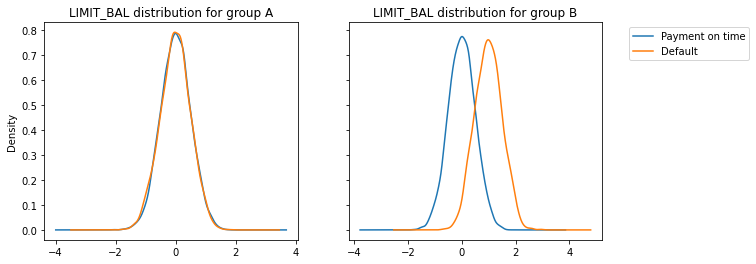

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

# LIMIT_BAL distribution by outcome, group A
dataset['LIMIT_BAL'][(A==1) & (Y==0)].plot(kind='kde', label="Payment on time", ax=ax1, 
                                           title="LIMIT_BAL distribution for group A")
dataset['LIMIT_BAL'][(A==1) & (Y==1)].plot(kind='kde', label="Default", ax=ax1)

# LIMIT_BAL distribution by outcome, group B
dataset['LIMIT_BAL'][(A==2) & (Y==0)].plot(kind='kde', label="Payment on time", ax=ax2, 
                                           legend=True, title="LIMIT_BAL distribution for group B")
dataset['LIMIT_BAL'][(A==2) & (Y==1)].plot(kind='kde', label="Default", ax=ax2, 
                                           legend=True).legend(bbox_to_anchor=(1.6, 1))
plt.show()

We wish to remain agnostic to the choice of classifier. The only major requirement is that it must be possible to fit the classifier using provided sample weights.

In [28]:
df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(
    dataset.drop(columns=['X', 'default payment next month']), 
    Y, 
    A, 
    A_str,
    test_size = 0.3, 
    random_state=12345,
    stratify=Y)

In [29]:
# train a naive (i.e. fairness-unaware) classifier
tree_naive = DecisionTreeClassifier(max_depth=4).fit(df_train, Y_train)

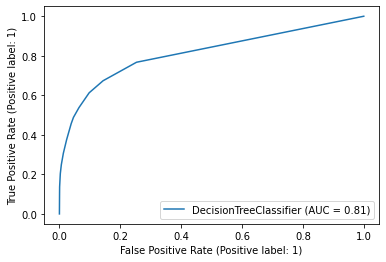

In [30]:
plot_roc_curve(tree_naive, df_train, Y_train)

In [31]:
feat_imps = tree_naive.feature_importances_

print('Importances:')
for x in np.argsort(feat_imps)[::-1][:5]: # restrict to top 5 features
    print('{} : {:.4f}'.format(df_train.columns[x], feat_imps[x]))

Importances:
LIMIT_BAL : 0.6174
PAY_1 : 0.3156
PAY_2 : 0.0529
PAY_AMT1 : 0.0084
PAY_6 : 0.0046


Now lets implement our fairness criteria and evaluate the naive model.

In [32]:
def demo_parity_table(preds, A):
    attr_probs = {a : preds[A==a].mean() for a in np.unique(A)}
    return pd.DataFrame({'P(f(X)=1 | A=a)': attr_probs, 'P(f(X)=1)' : preds.mean()}).T

def eq_odds_table(preds, A, Y):
    res = {}
    for a in np.unique(A):
        a_ix = A==a
        preds_a = preds[a_ix]
        Y_a = Y[a_ix]
        
        res[a] = {'TPR' : np.mean(Y_a * preds_a)/np.mean(Y_a),
                  'FPR': np.mean((1-Y_a)*preds_a)/np.mean(1-Y_a)}
    return pd.DataFrame(res)

In [33]:
train_scores = tree_naive.predict_proba(df_train)[:, 1]
train_preds = (train_scores >= np.mean(Y_train))*1.0

test_scores = tree_naive.predict_proba(df_test)[:, 1]
test_preds = (test_scores >= np.mean(Y_train))*1.0

In [34]:
dpt = demo_parity_table(train_preds, A_str_train)
dpt

,Group A,Group B
P(f(X)=1 | A=a),0.239762,0.274603
P(f(X)=1),0.260667,0.260667


In [35]:
eot = eq_odds_table(train_preds, A_str_train, Y_train)
eot

,Group A,Group B
TPR,0.513820,0.797251
FPR,0.152651,0.137461


__Exercise 3.1__: Above, we saw that equalized odds is equivalent to equal TPR and FPR within each attribute level, and thus equivalent to pointwise equality of the per-attribute ROC curves. Implement the function `attr_ROC_curves` below to compute an ROC curve for each level of the attribute $A$. Plot the curves. What do you see?

In [36]:
def attr_ROC_curves(cls, X, A, Y, tau_range = np.linspace(0,1,51)):
    ## <YOUR CODE HERE>
    res = {}
    all_probs = cls.predict_proba(X)[:, 1]
    for a in np.unique(A):
        res[a] = []
        prob_a = all_probs[A==a]
        Ya = Y[A==a]
        for t in tau_range:
            pred = prob_a > t
            res[a] += [(np.mean(pred[Ya==0]), np.mean(pred[Ya==1]))] 
    return tau_range, res

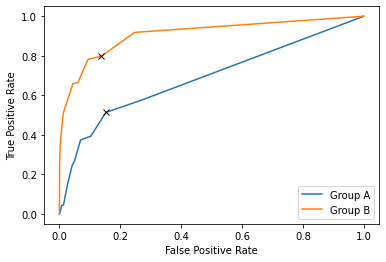

In [37]:
taus, roc = attr_ROC_curves(tree_naive, df_train, A_str_train, Y_train)

for a in roc.keys():
    fp = [x[0] for x in roc[a]]
    tp = [x[1] for x in roc[a]]
    
    plt.plot(fp, tp, label=a)
    ix = np.argmin(np.abs(taus-Y_train.mean())) # decision threshold
    plt.plot(fp[ix], tp[ix], 'kx')
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

Below, we implement a code block that generates a summary of the classifier in terms of both fairness and accuracy criteria.

__Exercise 3.2__: The "AUC difference" is defined as the maximum difference in AUC between all pairs of per-attribute ROC curves. Implement the function `AUC_diff` below given a set of classifier scores, the true label $Y$, and the attribute vector $A$.

In [38]:
def TPR_diff(eot):
    return eot.loc['TPR'].diff().abs().max()

def FPR_diff(eot):
    return eot.loc['FPR'].diff().abs().max()

def eo_diff(eot):
    return np.maximum(FPR_diff(eot), TPR_diff(eot))

def dp_diff(dpt):
    return dpt.loc['P(f(X)=1 | A=a)'].diff().abs().max()

def dp_ratio(dpt):
    return np.min(dpt.loc['P(f(X)=1 | A=a)'].values / dpt.loc['P(f(X)=1 | A=a)'].iloc[::-1].values)

def auc_diff(scores, A, Y):
    ## <YOUR CODE HERE>
    return np.abs(np.diff([roc_auc_score(Y[A==a], scores[A==a]) for a in A.unique()])[0])

def metrics_df(models_dict, Y, A):
    metrics_dict = {
        'Demo. parity difference' : (
        lambda x : dp_diff(demo_parity_table(x, A)), True),
        'Demo. parity ratio' : (
        lambda x : dp_ratio(demo_parity_table(x, A)), True),
        '----------' : (lambda x: " ", False),
        'True positive rate difference' : (lambda x: TPR_diff(eq_odds_table(x, A, Y)), True),
        'False positive rate difference' : (lambda x: FPR_diff(eq_odds_table(x, A, Y)), True),
        'Equalized odds difference' : (lambda x: eo_diff(eq_odds_table(x, A, Y)), True),
        '--------- ' : (lambda x: " ", False),
        'Overal AUC' : (lambda x: roc_auc_score(Y, x), False),
        'AUC difference' : (lambda x: auc_diff(x, A, Y), False)
    }
    df = {}
    for met_name, (fn, use_preds) in metrics_dict.items():
        df[met_name] = [fn(preds) if use_preds else fn(scores) 
                                for model, (preds, scores) in models_dict.items()]
        
    return pd.DataFrame.from_dict(df, orient="index", columns=models_dict.keys())

In [39]:
models_dict = {"Naive": (test_preds, test_scores)}
metrics_df(models_dict, Y_test, A_str_test)

,Naive
Demo. parity difference,0.032372
Demo. parity ratio,0.879355
----------,
True positive rate difference,0.287474
False positive rate difference,0.018392
Equalized odds difference,0.287474
---------,
Overal AUC,0.814779
AUC difference,0.215847


#### 3.3 Training fairness-aware classifiers

Finally, we explore the tradeoff between fairness and accuracy by generating a sequence of models that differ in their relative prioritization of equalized odds versus fit to the training data. A key insight, due to [Aggarwal et al. (2018)](https://arxiv.org/abs/1803.02453), is that the problem of (approximately) fair classification can be reduced to optimizing the classifier in standard fashion, but with unequal sample weights.

The weighting scheme and various helper methods are implemented in the `fairlearn` package.

In [40]:
!conda install -y -c conda-forge fairlearn

Solving environment: done

## Package Plan ##

  environment location: /home/avsharma/anaconda3/envs/DATA558

  added / updated specs:
    - fairlearn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    fairlearn-0.6.2            |     pyhd8ed1ab_0        20.3 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        20.3 MB

The following NEW packages will be INSTALLED:

  fairlearn          conda-forge/noarch::fairlearn-0.6.2-pyhd8ed1ab_0



fairlearn-0.6.2      | 20.3 MB   | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [41]:
from fairlearn.reductions import GridSearch, EqualizedOdds
from fairlearn.metrics import equalized_odds_difference

We'll begin our fairness-aware pipeline by resampling the data to obtain balance between the classes.

In [42]:
# balanced sampling of train data
balanced_idx1 = df_train[Y_train==1].index
pp_train_idx = balanced_idx1.union(Y_train[Y_train==0].sample(n=balanced_idx1.size, random_state=1234).index)

df_train_balanced = df_train.loc[pp_train_idx, :]
Y_train_balanced = Y_train.loc[pp_train_idx]
A_train_balanced = A_train.loc[pp_train_idx]

Next we use the `fairlearn` class `GridSearch` to train a sequence of models that feature varying levels of penalization for their violation of the equalized odds criterion. The API is designed to mimic that of `sklearn`, and any `sklearn` classifier featuring a `fit()` method with `sample_weights` keyword argument can be used.

In [43]:
# sweep over penalization levels for violation of equalized odds criterion
model = DecisionTreeClassifier(max_depth=4)

sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=50,
                   grid_limit=3)

sweep.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

In [44]:
# compute scores, predictions, and fairness / accuracy metrics for each model in the sweep
sweep_preds = [predictor.predict(df_test) for predictor in sweep.predictors_] 
sweep_scores = [predictor.predict_proba(df_test)[:, 1] for predictor in sweep.predictors_]

equalized_odds_sweep = [
    equalized_odds_difference(Y_test, preds, sensitive_features=A_str_test)
    for preds in sweep_preds
]
balanced_accuracy_sweep = [balanced_accuracy_score(Y_test, preds) for preds in sweep_preds]
auc_sweep = [roc_auc_score(Y_test, scores) for scores in sweep_scores]

After computing fairness and accuracy metrics, we can reject any model that is simultaneously _less fair_ and _less accuracte_ than (i.e. "dominated by") another model in the grid search sweep.

In [45]:
all_results = pd.DataFrame(
    {"predictor": sweep.predictors_, "accuracy": balanced_accuracy_sweep, "disparity": equalized_odds_sweep}
) 
non_dominated = [] 
for row in all_results.itertuples(): 
    accuracy_for_lower_or_eq_disparity = all_results["accuracy"][all_results["disparity"] <= row.disparity] 
    if row.accuracy >= accuracy_for_lower_or_eq_disparity.max(): 
        non_dominated.append(True)
    else:
        non_dominated.append(False)

equalized_odds_sweep_non_dominated = np.asarray(equalized_odds_sweep)[non_dominated]
balanced_accuracy_non_dominated = np.asarray(balanced_accuracy_sweep)[non_dominated]
auc_non_dominated = np.asarray(auc_sweep)[non_dominated]

Finally, we can plot the results to view the tradeoff between fairness and accuracy for this dataset and classifier.

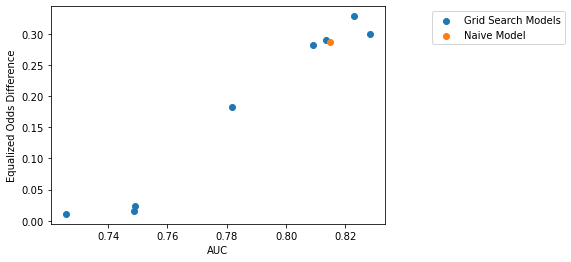

In [46]:
# plot results 
plt.scatter(auc_non_dominated, equalized_odds_sweep_non_dominated, label="Grid Search Models")
plt.scatter(roc_auc_score(Y_test, test_scores),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Naive Model")

plt.xlabel("AUC")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

In [47]:
grid_search_dict = {"GridSearch_{}".format(i): (sweep_preds[i], sweep_scores[i])
                    for i in range(len(sweep_preds))
                    if non_dominated[i] and equalized_odds_sweep[i]<0.1}
models_dict.update(grid_search_dict)
metrics_df(models_dict, Y_test, A_str_test)

,Naive,GridSearch_37,GridSearch_38,GridSearch_39
Demo. parity difference,0.032372,0.005451,0.024403,0.032327
Demo. parity ratio,0.879355,0.983942,0.90511,0.884232
----------,,,,
True positive rate difference,0.287474,0.010887,0.005154,0.000102
False positive rate difference,0.018392,0.007245,0.014774,0.023307
Equalized odds difference,0.287474,0.010887,0.014774,0.023307
---------,,,,
Overal AUC,0.814779,0.725747,0.748887,0.749149
AUC difference,0.215847,0.002775,0.00118,0.006275


__Exercise 3.3__: Explore the above analysis in greater depth by answering the following questions:

- What happens if you don't train on a balanced sample?
- What's the difference in accuracy-fairness tradeoff for a logistic regression vs decision tree classifier?
- How do you enforce a constraint on demographic parity rather than equalized odds?